# **Diplomado IA: Inteligencia Artificial I - Parte 2**. <br> Laboratorio 4: Data Augmentation, Transferencia de conocimiento y Finetuning
---
---

**Profesores:**
- Julio Hurtado
- Felipe del Río

**Ayudante:**
- Mathias Lambert
---
---

# **Instrucciones Generales**

El siguiente práctico se debe realizar **individualmente**. El formato de entregar es el **archivo .ipynb con todas las celdas ejecutadas**. Todas las preguntas deben ser respondida en celdas de texto. No se aceptará el _output_ de una celda de código como respuesta.

**Nombre compañero 1:** Ariel Carvajal

**Fecha de entrega: Viernes 4 de junio.**

El siguiente práctico cuanta con 2 secciones donde cada una contendrá 1 o más actividades a realizar. Algunas actividades correspondrán a escribir código y otras a responder preguntas. 

**Importante.** Para facilitar su ejecución, cada sección puede ser ejecutada independientemente.

Se recomienda **fuertemente** revisar las secciones donde se entrega código porque algunas actividades de código pueden reutilizar el mismo código pero con cambios en algunas líneas.



# **Agenda**

>[Diplomado IA: Inteligencia Artificial I - Parte 2.  Laboratorio 4: Data Augmentation, Transferencia de conocimiento y Finetuning](#scrollTo=tHopPtVaNF1K)

>[Instrucciones Generales](#scrollTo=uIdAKAdELPSl)

>[Agenda](#scrollTo=kEloa5uXLIPK)

>[Actividad I: Imágenes](#scrollTo=HOa9JfE2WfUb)

>>[Preámbulo](#scrollTo=CDBGNG3R4I8r)

>>[Primeros Pasos](#scrollTo=7AJawpaKoGdK)

>>>[Dataset](#scrollTo=OZDH2UsI89UR)

>>>[Entrenamos un Modelo Base](#scrollTo=-QFHlOSR9BYd)

>>[Aumentación de Datos](#scrollTo=mMygBiPcsCIz)

>>>[Reflexiones](#scrollTo=SAbGkA9R0r9m)

>>>[Recortes](#scrollTo=psPyBfTK0xsQ)

>>>[Rotaciones](#scrollTo=gESEMUPg0_xQ)

>>>[Transformaciones Afín](#scrollTo=QkBQAG8EX5sf)

>>>[Composición de transformaciones](#scrollTo=EVxbSK-Q1EQT)

>>>[Transformaciones custom](#scrollTo=7nIxe7hHHvfu)

>>>[Ejercicio I](#scrollTo=4f--FBKjlszW)

>>[Transfer Learning y Finetuning](#scrollTo=UQhGTF-8IB71)

>>>[Finetuning](#scrollTo=131YF5zEX4_R)

>>>[Ejercicio II](#scrollTo=ZzomWbLeh2YB)

>[Actividad II: Texto](#scrollTo=_hc0eXMnHZsC)

>>[Preámbulo](#scrollTo=O4Qfqe2Sr1Mc)

>>[Primeros Pasos](#scrollTo=TjVrxQAUw7iB)

>>>[Dataset](#scrollTo=TjVrxQAUw7iB)

>>[Modelo Base](#scrollTo=dvMVR6Ux5YGA)

>>[Finetuning](#scrollTo=NiztGI2ILH06)

>>[Ejercicio III](#scrollTo=4VGwV1D6UlxF)

>[Anexo](#scrollTo=kX7ogfKfhOfl)

>>[¿Cómo entrenar algunas capas del modelo?](#scrollTo=toCtK7zTeXNc)



# Actividad I: Imágenes

En esta actividad aplicaremos lo que vimos en clase para un problema de clasificación de imágenes. Veremos como aplicar *data augmentation* y usar finetuning para este dominio en particular.

<small>Agradecemos a Hernán Valdivieso por su script para descargar archivos desde Google Drive.</small>

## Preámbulo

Primero debemos copiar el dataset hacia colab para luego decomprimirlo dentro del directorio `data`, que recién creamos. También importamos algunas de las librerías que ocuparemos durante esta actividad.

In [ ]:
![[ ! -f google_api.py ]] && wget -q --show-progress https://raw.githubusercontent.com/Hernan4444/MyScripts/master/google_drive/google_api.py
!mkdir -p data

In [ ]:
# !pip install torch==1.7.0
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import os
from google_api import download_file_without_authenticate

# Descargamos nuestros datos para ser utilizados en este notebook.
if not os.path.exists('lab4.zip'): 
    download_file_without_authenticate(
        '1NjcTV1SeZgYWOAZG-ig2NBpYP5EyTy8Z', 'data/jigsaw-toxic-comment-classification-challenge.zip')
    download_file_without_authenticate(
        '1ye0M-KnVtUbpIgGjogIjgWx0vReCthWA', 'data/flowers.zip')
    
!unzip -nq data/\*.zip -d data

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
import random
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# No tocar este código
random.seed(1666)
rng_state = np.random.get_state()
np.random.seed(1666)
torch.manual_seed(1666)
torch.cuda.manual_seed(1666)

## Primeros Pasos

En la gran mayoría de aplicaciones con las que se encontraran en el mundo real, difícilmente podrán tener una cantidad de **datos etiquetados** suficientes para entrenar un red neuronal profunda como las que han visto hasta ahora. 

En esta actividad práctica veremos como enfrentarnos a esta situación utilizando las herramientas que vimos en clase y la librería PyTorch

### Dataset 

Trabajaremos con el dataset **flowers**, el cual ya utilizaron anteriormente. Este dataset está compuesto por imágenes de flores centradas. Las imágenes son de tamaño variable. Y la tarea a realizar es la de clasificación de la especie que aparece en cada imágen.

Si ejecutaron el código anterior, ya tenemos nuestro dataset en el directorio `data`.

Luego, debemos crear un objeto de la clase `Dataset`, para eso nos ayudaremos con la clase `torchvision.datasets.ImageFolder`, que hereda de esta, y utilizaremos durante esta actividad. En este caso ya tenemos divididos los distintos sets que utilizaremos (`train`, `val` y `test`), cada uno en su propio directorio y además agregamos un directorio `all`, que contiene la totalidad de los datos que también utilizaremos.

In [ ]:
from torchvision.datasets import ImageFolder

root_dir = 'data/flowers'
flowers_dataset = ImageFolder(f'{root_dir}/all')
train_dataset = ImageFolder(f'{root_dir}/train/')
val_dataset = ImageFolder(f'{root_dir}/val/')
test_dataset = ImageFolder(f'{root_dir}/test/')

Exploremos los datos para que podamos ver algunas de las características que estos tienen. Primero veamos con cuantos datos contamos.

In [ ]:
for split, ds in [('totales', flowers_dataset), ('train', train_dataset), ('val', val_dataset), ('test', test_dataset)]:
    print('{:<18s}{:>6,d}'.format(f'Imágenes {split}:', len(ds)))

Imágenes totales:  8,189
Imágenes train:    5,687
Imágenes val:      1,224
Imágenes test:     1,278


Podemos ver algunas de las clases, aleatoriamente elegidas, en que están etiquetadas nuestras imágenes. Además veamos como se ven los datos, elijamos ejemplos aleatorios con su clase y mostremoslos. 

**Insight.** Siempre es importante revisar manualmente los datos. Así nos hacemos una mejor idea de las características del dataset y podemos sacar *insights* que nos ayuden a mejorar el rendimiento de los modelos que vayamos a entrenar.

In [ ]:
for label in random.choices(flowers_dataset.classes, k=10):
    print(label)

mallow
red ginger
magnolia
artichoke
frangipani
trumpet creeper
columbine
corn poppy
bishop of llandaff
magnolia


Tamaño imagen: 666x500
Etiqueta:      tree mallow


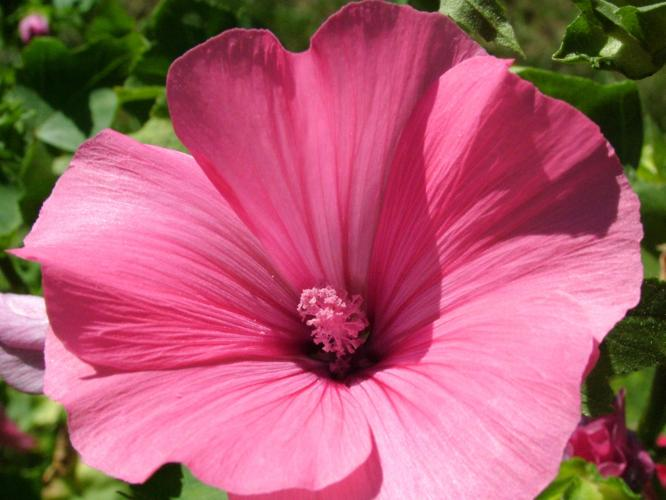

In [ ]:
ridx = random.randint(0, len(flowers_dataset))
sample_img, sample_class = flowers_dataset[ridx]

w, h = sample_img.size
class_ = flowers_dataset.classes[sample_class]

print(f'Tamaño imagen: {w}x{h}')
print(f'Etiqueta:      {class_}')
sample_img

### Entrenamos un Modelo Base

Habiendo explorados los datos, prosigamos a entrenar un modelo base. Este modelo nos servirá para poder tener un punto de comparación, y así tener una mejor idea de cuanto ayuda usar las técnicas que vimos en clases. Entrenaremos un modelo típico para esta tarea, una [ResNet18](https://arxiv.org/abs/1512.03385) que es un modelo simple y liviano para mostrar. De todas maneras una mejora simple y directa que se puede hacer es utilizar una *ResNet* de mayor número de capas, i.e. 34, 50, 101 o 152, lo cual debería mejorar el rendimiento de clasificador.

Partiremos inicializando los distintos hiperparámetros que utilizaremos durante este práctico.

In [ ]:
import torch.nn as nn

batch_size = 128 #@param {type:"number"}
learning_rate = 5E-4 #@param {type:"number"}
n_epochs = 5 # @param {type:"slider", min:1, max:20, step:1}

In [ ]:
criterion = nn.CrossEntropyLoss()
n_classes = len(flowers_dataset.classes)

Creemos los data loaders, los cuales nos permitiran armar batches para el entrenamiento. Además nos ayudarán entregandonos los datos de forma desordenada o aleatoria, como habrán visto en clases anteriores, esto siempre es recomendable pero solo es necesario para el set de entrenamiento.

In [ ]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True), # shuffle = aleatorio 
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False),
}

Para ahorrarnos trabajo, utilizaremos transformaciones. En primera instancia, solo nos preocuparemos de que todas las imágenes sean del mismo tamaño y están normalizadas. Además nos ayudaremos transformando automáticamente la imagen a un `torch.Tensor`, el cual podremos utilizar para el entrenamiento. Más adelante las utilizaremos para hacer *Data Augmentation*.

In [ ]:
from torchvision import transforms

# Pixel medio y std de Imagenet
mean_pixel = [0.485, 0.456, 0.406]
std_pixel = [0.229, 0.224, 0.225]

to_normalized_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_pixel, std=std_pixel),
])
train_dataset.transform = transforms.Compose([
    transforms.Resize([224, 224]),
    to_normalized_tensor
])
val_dataset.transform = transforms.Compose([
    transforms.Resize([224, 224]),
    to_normalized_tensor
])
test_dataset.transform = transforms.Compose([
    transforms.Resize([224, 224]),
    to_normalized_tensor
])


Además, crearemos varias funciones que nos ayudarán el entrenaminto de modelos reiteradas veces en este práctico. Les recomendamos que traten de entender cada una de estas funciones pues podrán reforzar conocimientos que ya han aprendido en el diplomado hasta ahora, pero para efectos de esta actividad no es necesario hacerlo.

In [ ]:
import torchvision.models as models

def get_model(n_classes, pretrained=None):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)
    model.to(device) # Envíamos el modelo a la GPU si está disponible
    return model

def run_epoch(phase, model, loader, criterion, optimizer=None):
    n_batches = len(loader)
    if phase == 'train':
        model.train()
    elif phase == 'val' or 'test':
        model.eval()
        
    cum_loss = 0.0
    cum_acc = 0.0
    for n_batch, (x, y) in enumerate(loader, start=1):
        if phase == 'train': # Limpiamos los gradientes solo al entrenar
            optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)
        result = model(x) # Aquí se ejecuta nuestro modelo

        loss = criterion(result, y) # Calculamos la pérdida
        cum_loss += loss.item()
        _, preds = torch.max(result, 1) # Nuestra predicción es la salida de mayor valor entre las 10 posibles
        cum_acc += torch.sum(preds == y.data)
        if phase == 'train':
            loss.backward() # Hacemos backpropagation solo en train
            optimizer.step() # Actualizamos parámetros solo en train

        current_cum_loss = cum_loss / n_batch
        current_cum_acc = 100 * cum_acc / (n_batch * batch_size)
        print(f'\r{phase.upper()}-Batch {n_batch}/{n_batches} '
              f'Loss: {current_cum_loss:.4f} Acc: {current_cum_acc:.2f}%', end='')
    
    epoch_loss = float(cum_loss / n_batch)
    epoch_acc = float(100 * cum_acc / (n_batch * batch_size))
    return epoch_loss, epoch_acc

def run_training(model, loaders, optimizer, criterion, n_epochs):
    phases = ['train', 'val']
    history = {
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': []}
    }

    print(f"Validating model before training")
    val_loss, val_acc = run_epoch('val', model, loaders['val'], criterion)
    print()
    history['val']['loss'].append(val_loss)
    history['val']['acc'].append(val_acc)
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch N°{epoch}")
        for phase in phases:
            epoch_loss, epoch_acc = run_epoch(phase, model, loaders[phase], criterion, optimizer=optimizer)

            # Registramos las pérdidas y accuracy por época, por fase
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            print("")

    return history

def run_testing(model, loader, criterion, n_epochs):
    test_loss, test_acc = run_epoch('test', model, loader, criterion)
    print(f'\n\nTest loss: {test_loss:.4f}, Test acc.: {test_acc:.2f}\n')
    return {'loss': test_loss, 'acc': test_acc}

Definamos también algunas funciones que nos ayudarán a visualizar el entrenamiento y sus resultados de mejor forma.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image

def graph_metrics(metricas_test, metricas_train, title=''):
    fig, ax = plt.subplots()
    plt.style.use('seaborn-white')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
    plt.plot(range(1, int(len(metricas_train)+1)), metricas_train, marker='o')
    plt.plot(range(int(len(metricas_test))), metricas_test, marker='o')
    plt.legend(['Train', 'Val'])
    plt.title(title)
    plt.show()

def graph_training_metrics(history):
    for metric in ['loss', 'acc']:
        title = f'{metric.capitalize()} vs N° Épocas'
        graph_metrics(history['val'][metric], history['train'][metric], title=title)

def print_report(train_history, test_performance):
    graph_training_metrics(train_history)

    train_loss = train_history['train']['loss'][-1]
    train_acc = train_history['train']['acc'][-1]
    val_loss = train_history['val']['loss'][-1]
    val_acc = train_history['val']['acc'][-1]
    test_loss = test_performance['loss']
    test_acc = test_performance['acc']
    print(f'Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%')

def bold(text):
  return '\033[1m' + text + '\033[0m'

def show_prediction(model, dataset, sample_idx=None, topk=5):
    if sample_idx is None:
        sample_idx = random.randrange(len(dataset))

    image_path, label = dataset.samples[sample_idx]
    label = flowers_dataset.classes[label]

    x, y = dataset[sample_idx]
    x = x.to(device)
    x = x.unsqueeze(dim=0)
    probs = nn.functional.softmax(model(x), dim=1)
    topk_probs, topk_classes = torch.topk(probs, k=topk)
    print(bold('Ground Truth'))
    print(label, end='\n\n')

    print(bold(f'Top-{topk} Predictions'))
    for prob, label_idx in zip(topk_probs.squeeze(), topk_classes.squeeze()):
        label_idx, prob = int(label_idx), float(prob)
        print('{:<19} (p={:.4f})'.format(flowers_dataset.classes[label_idx], prob))

    print()
    return Image.open(image_path)

Luego, utilizamos las funciones que acabamos de crear, para entrenar nuestro primer  y ver como le va.

In [ ]:
from torch.optim import Adam

model = get_model(n_classes=n_classes)
optimizer = Adam(model.parameters(), lr=learning_rate)

history = run_training(model, loaders, optimizer, criterion, n_epochs)

Validating model before training
VAL-Batch 10/10 Loss: 5.2811 Acc: 1.72%
Epoch N°1
TRAIN-Batch 45/45 Loss: 3.5376 Acc: 17.05%
VAL-Batch 10/10 Loss: 3.2131 Acc: 20.00%
Epoch N°2
TRAIN-Batch 45/45 Loss: 2.7004 Acc: 30.94%
VAL-Batch 10/10 Loss: 2.8698 Acc: 26.56%
Epoch N°3
TRAIN-Batch 45/45 Loss: 2.3130 Acc: 38.40%
VAL-Batch 10/10 Loss: 2.6133 Acc: 32.19%
Epoch N°4
TRAIN-Batch 45/45 Loss: 2.0494 Acc: 44.48%
VAL-Batch 10/10 Loss: 2.3298 Acc: 37.66%
Epoch N°5
TRAIN-Batch 45/45 Loss: 1.8115 Acc: 49.86%
VAL-Batch 10/10 Loss: 2.2320 Acc: 39.61%


También procedemos a ver su rendimiento final en el set de test.

TEST-Batch 10/10 Loss: 2.1767 Acc: 42.11%

Test loss: 2.1767, Test acc.: 42.11



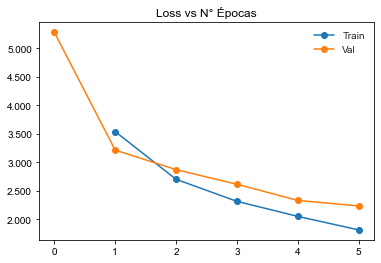

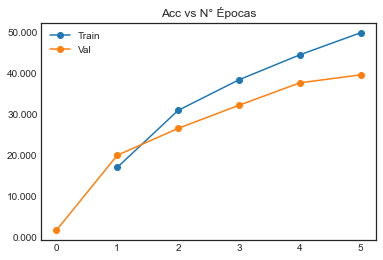

Train Loss: 1.8115 - Train Acc: 49.86%
Val Loss: 2.2320 - Val Acc: 39.61%
Test Loss: 2.1767 - Test Acc: 42.11%


In [ ]:
test_performance = run_testing(model, loaders['test'], criterion, n_epochs)

print_report(history, test_performance)

Inspeccionemos la predicción del modelo para un ejemplo.

Ground Truth
lenten rose

Top-5 Predictions
lenten rose         (p=0.7556)
wild pansy          (p=0.0443)
columbine           (p=0.0343)
frangipani          (p=0.0281)
mallow              (p=0.0245)



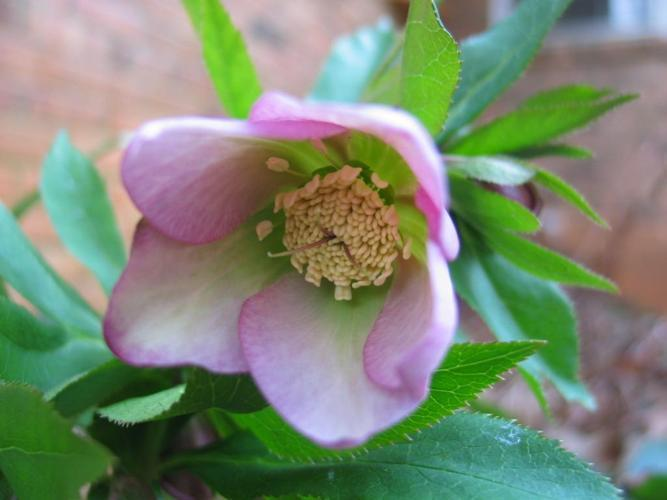

In [ ]:
show_prediction(model, test_dataset)  # Si omiten el sample_idx este será elegido aleatoriamente

## Aumentación de Datos

Hasta ahora solo hemos repasado contenidos que ya habían visto, de manera que podamos tener un modelo con cual compararnos. Ahora veremos como utlizar *Data Augmentation*, para, en lo posible, mejorar el rendimiento de nuestro modelo.

Como vimos en clase podemos aumentar de forma artificial nuestro set de datos utilizando distintas técnicas. A continuación veremos algunas de las técnicas más utilizadas, veremos como se ven visualmente, cómo se aplican en el entrenamiento de forma fácil utilizando PyTorch y el resultado que estas tienen sobre el entrenamiento.

Para efectuar data augmentation en imágenes, PyTorch nos ayuda con la librería `tochvision.transforms`, esta librería no es exclusiva para este uso pero podemos aprovecharla para facilitarnos la vida ya que cuenta con las transformaciones más comunes que se hacen sobre imágenes en este contexto.

Crearemos funciones que nos permiten aplicarlas y visualizar su resultado.

In [ ]:
def n_sample_from_m_imgs(dataset, n_samples, m_images, rand=True):
    imgs = []
    for i in range(m_images):
        ridx = random.randint(0, len(dataset)) if rand else i
        sample_imgs = []
        for j in range(n_samples):
            sample_img, _ = dataset[ridx]
            sample_imgs.append(sample_img)
        imgs.append(sample_imgs)
    return imgs

def display_image_grid(images):
    rows = len(images)
    columns = len(images[0])

    figure, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(1.5 * columns, 1.5 * rows))
    for row_axes, row_imgs  in zip(axes, images):
        for ax, img in zip(row_axes, row_imgs):
            ax.imshow(img)
            ax.axis('off')

Ahora veamos el resultados de algunas de estas.

### Reflexiones

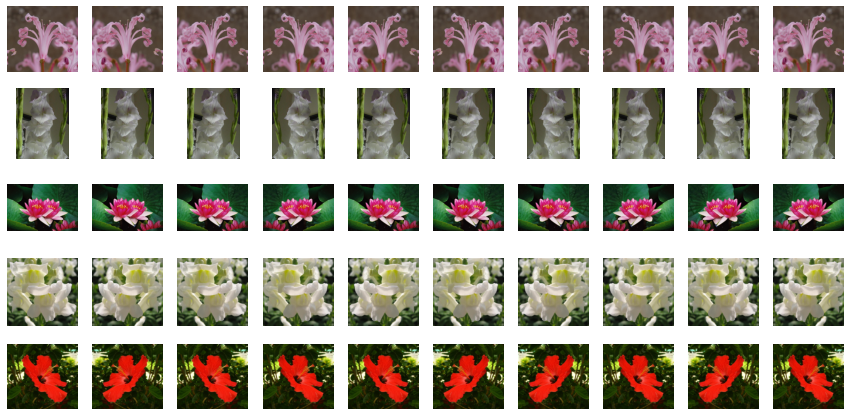

In [ ]:
flowers_dataset.transform = transforms.RandomHorizontalFlip(p=0.5)

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Recortes

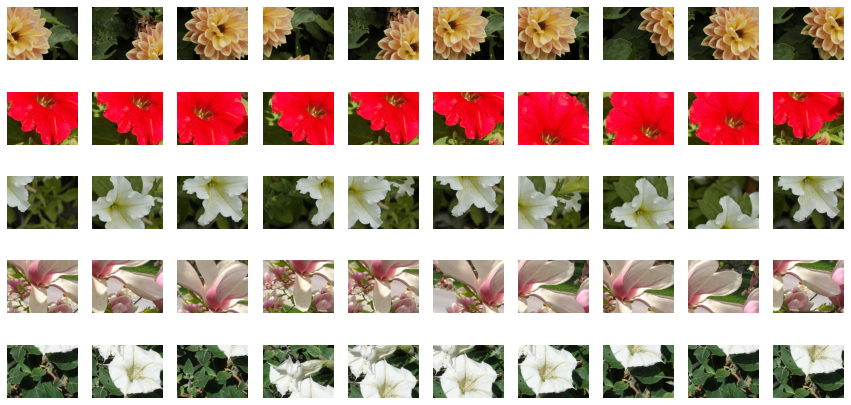

In [ ]:
flowers_dataset.transform = transforms.RandomCrop(size=(240, 320), pad_if_needed=True)

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Rotaciones

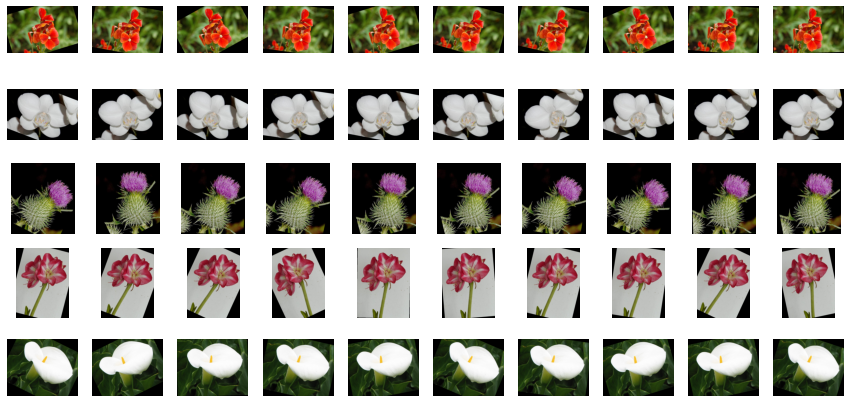

In [ ]:
flowers_dataset.transform = transforms.RandomRotation((-30, 30))

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Transformaciones Afín

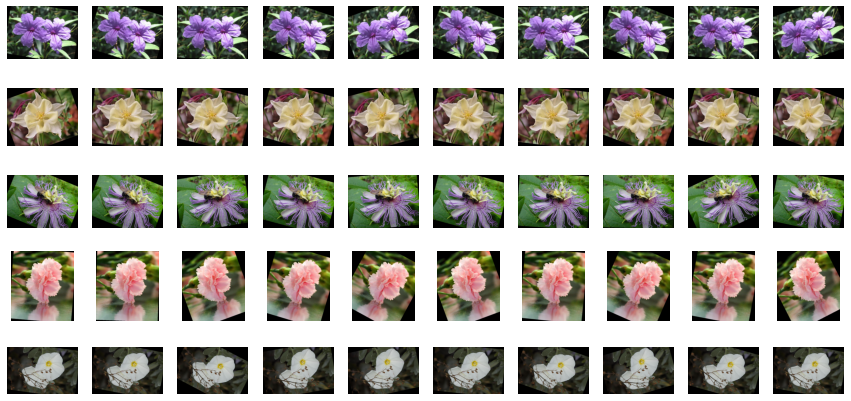

In [ ]:
flowers_dataset.transform = transforms.RandomAffine(30)

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Composición de transformaciones

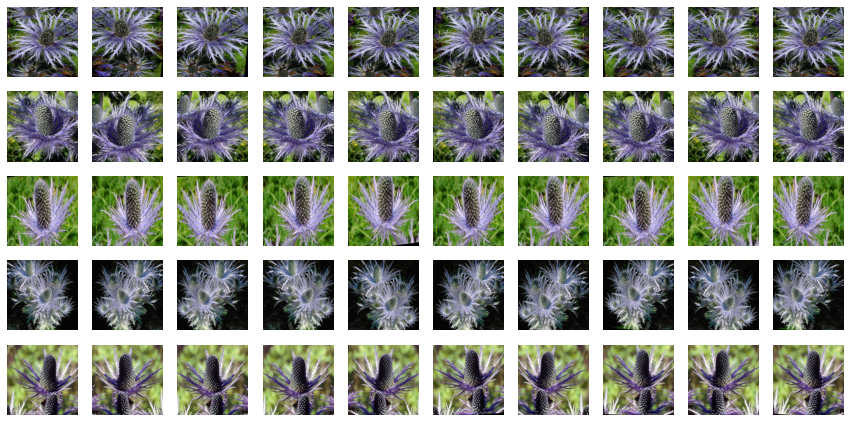

In [ ]:
randomized_transforms = transforms.Compose([
    transforms.RandomRotation((-5, 5)), 
    transforms.Resize([256, 256]),
    transforms.RandomCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
])

flowers_dataset.transform = randomized_transforms
imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5, rand=False)
display_image_grid(imgs)

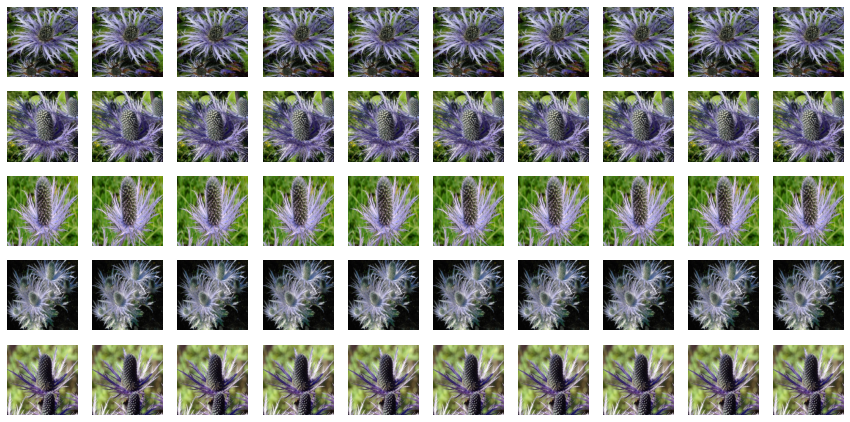

In [ ]:
deterministic_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.CenterCrop(size=(224, 224)),
])

flowers_dataset.transform = deterministic_transforms
imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5, rand=False)
display_image_grid(imgs)

Otras formas de aplicar transformaciones es utilizando `torchvision.transforms.RandomApply`, que aplica las transformaciones que contiene con una probabilidad $p$ y `torchvision.transforms.RandomChoice`, que aleatoriamente elige una transformación de una lista y la aplica.

### Transformaciones custom

También, podemos crear nuestras transformaciones propias fácilmente. Estas corresponden a objetos "llamables" en Python, es decir, objetos que implementan el método especial `__call__`. Esto permite que dichos objetos puedan ser llamados de la misma forma que una función.

A continuación pueden ver la forma que debe tener una transformación.

In [ ]:
from torch.nn import Module

class MyTransformation(Module):
    def __init__(self):
        pass

    def __call__(self, x):
        # Must return an image or tensor
        pass

Al ser `MyTransformation` una clase que implementa el método `__call__`, podemos llamarla igual que lo hacemos con las funciones, por ejemplo:

```python
transform = MyTransformation()
new_image = transform(image)
```

A continuación implementaremos una transformación que agrega ruido gaussiano a una imágen.

In [ ]:
from PIL import Image

class AddGaussianNoise(Module):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __call__(self, img):
        img = np.array(img)
        noise = np.random.normal(loc=self.mu, scale=self.sigma, size=img.shape)
        img = (img + noise).clip(0, 255).astype(np.uint8)
        return Image.fromarray(img)

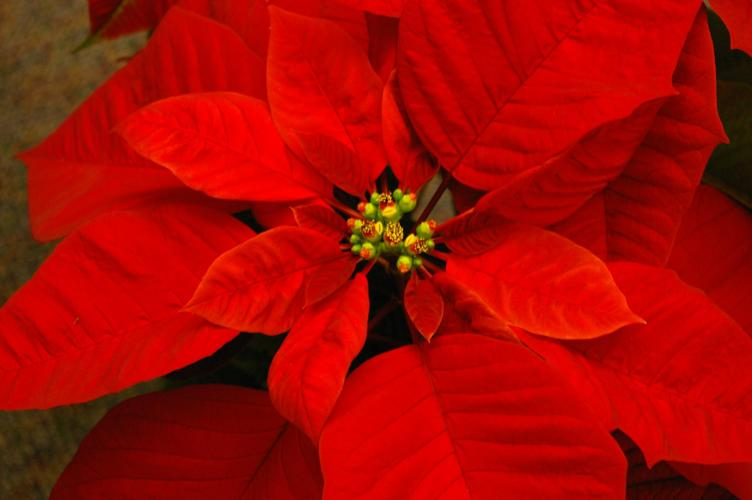

In [ ]:
flowers_dataset.transform = None

ridx = random.randint(0, len(flowers_dataset))
sample_img, sample_class = flowers_dataset[ridx]
sample_img

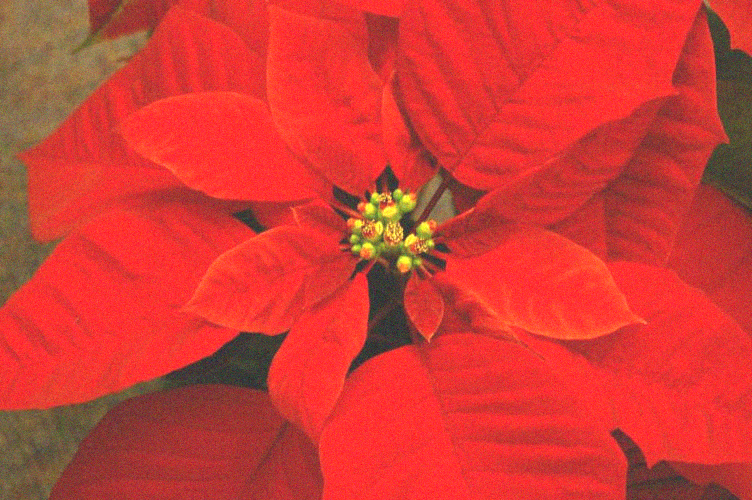

In [ ]:
flowers_dataset.transform = AddGaussianNoise(50,10)

sample_img, sample_class = flowers_dataset[ridx]
sample_img

Ahora entrenaremos otro modelo utilizando data augmentation para ver como afecta en su rendimiento en test. 

Para esto, primero debemos agregar la transformaciones que nos faltan para que la salida de nuestro dataset venga en forma de tensor y esté normalizado, igual que en el primer entrenamiento.

In [ ]:
train_dataset.transform = transforms.Compose([
    randomized_transforms,
    to_normalized_tensor     
])
val_dataset.transform = transforms.Compose([
    deterministic_transforms,
    to_normalized_tensor           
])
test_dataset.transform = transforms.Compose([
    deterministic_transforms,
    to_normalized_tensor             
])

Validating model before training
VAL-Batch 10/10 Loss: 5.2376 Acc: 0.86%
Epoch N°1
TRAIN-Batch 45/45 Loss: 3.5109 Acc: 17.15%
VAL-Batch 10/10 Loss: 3.7635 Acc: 15.08%
Epoch N°2
TRAIN-Batch 45/45 Loss: 2.6567 Acc: 31.74%
VAL-Batch 10/10 Loss: 2.8210 Acc: 26.48%
Epoch N°3
TRAIN-Batch 45/45 Loss: 2.3131 Acc: 38.07%
VAL-Batch 10/10 Loss: 2.7218 Acc: 28.75%
Epoch N°4
TRAIN-Batch 45/45 Loss: 2.0676 Acc: 42.83%
VAL-Batch 10/10 Loss: 2.3969 Acc: 34.45%
Epoch N°5
TRAIN-Batch 45/45 Loss: 1.8297 Acc: 49.36%
VAL-Batch 10/10 Loss: 2.2618 Acc: 39.14%
TEST-Batch 10/10 Loss: 2.3132 Acc: 39.30%

Test loss: 2.3132, Test acc.: 39.30



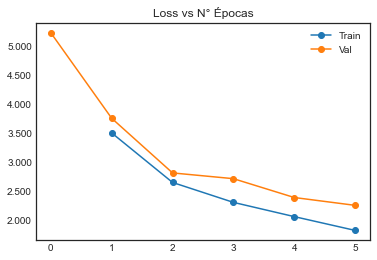

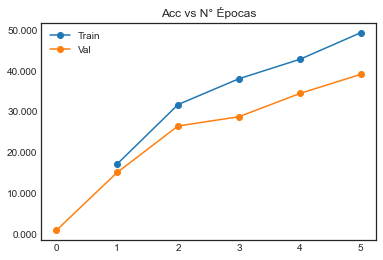

Train Loss: 1.8297 - Train Acc: 49.36%
Val Loss: 2.2618 - Val Acc: 39.14%
Test Loss: 2.3132 - Test Acc: 39.30%


In [ ]:
aug_model = get_model(n_classes=n_classes)

aug_optimizer = Adam(aug_model.parameters(), lr=learning_rate)

aug_history = run_training(aug_model, loaders, aug_optimizer, criterion, n_epochs)
aug_test_performance = run_testing(aug_model, loaders['test'], criterion, n_epochs)

print_report(aug_history, aug_test_performance)

Ground Truth
bougainvillea

Top-5 Predictions
lotus               (p=0.1775)
sweet pea           (p=0.0917)
petunia             (p=0.0746)
cyclamen            (p=0.0481)
mexican aster       (p=0.0442)



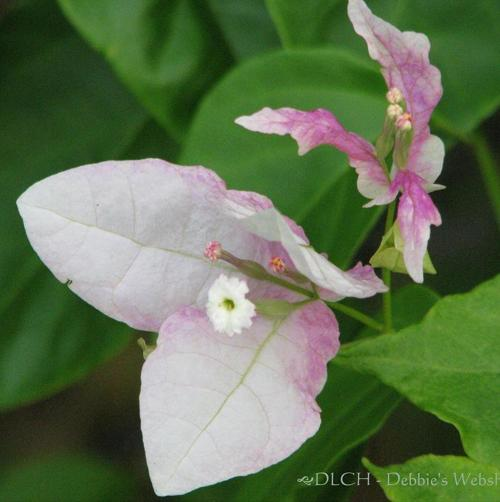

In [ ]:
show_prediction(aug_model, test_dataset, sample_idx=166) # Si omiten el sample_idx este será elegido aleatoriamente

### **Ejercicio I**
Cree su propia transformación, esta debe recibir una imagen y devolverla reflejada verticalmente. Luego pruébela para entrenar un modelo descomentando el código a continuación (esta será aplicada aleatoriamente con probabilidad $p=0.5$). Para ser creado el objeto transformación **no** debe recibir ningún parámetro.
- ¿Cómo se compara el rendimiento con nuestro modelo base? ¿Y con el modelo entrenado con data augmentation que habíamos probado previamente?
- Analice brevemente el resultado obtenido brevemente.

**Alternativa.** Puede inventar su propia operación para esta actividad (no debe estar implementada en la libraría de transformaciones). Debe explicar brevemente lo que hace, también tener cuidado que el nombre de la transformación debe ser consistente en el código de entrenamiento a continuación. **Esto dará una bonificación de 0.5pts.**

**Ayuda.** Para realizar este ejercicio le recomendamos familiarizarse con la librería [`PIL`](https://pillow.readthedocs.io/en/stable/reference/), específicamente la función [`Image.transpose`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.transpose). Si encuentra una forma alternativa de realizar esta operación, no dude en usarla.

In [ ]:
class VerticalFlipTransform(Module):
    def __init__(self):
        pass

    def __call__(self, img):
        return img.transpose(Image.FLIP_TOP_BOTTOM)

In [ ]:
# Un humano podría reconocer la imagen incluso con una seccion oculta :P
class HideWithBoxTransform(Module):
    def __init__(self):
        self.box_size = 200

    def __call__(self, img):
        img = np.array(img)
        h, w = img.shape[:2]
        
        # determinar la posicion de inicio de la caja
        x1, y1 = random.randint(0, w - self.box_size), random.randint(0, h - self.box_size)

        # determinar la posicion de fin de la caja
        x2, y2 = x1 + self.box_size, y1 + self.box_size

        # reemplazar los pixeles por colores aleatorios
        img[y1:y2, x1:x2] = [
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        ]

        return Image.fromarray(img)

Visualice su transformación y pruebe entrenar un modelo utilizandola.



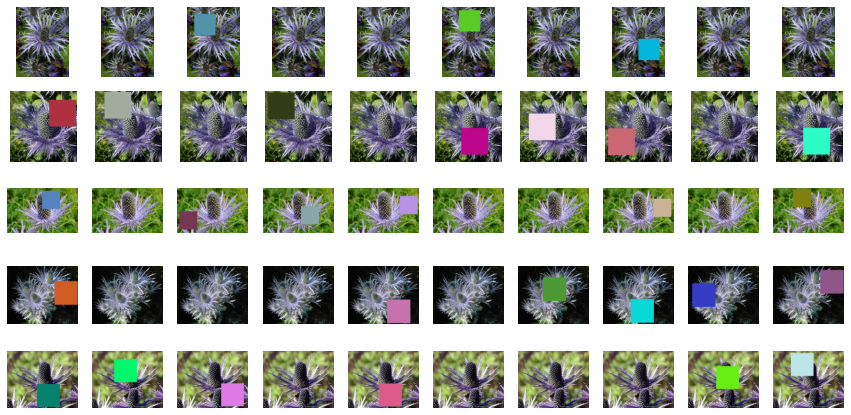

In [ ]:
from torch.nn import ModuleList

flowers_dataset.transform = transforms.RandomApply(
    ModuleList([HideWithBoxTransform()]), p=0.5)
    
imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5, rand=False)
display_image_grid(imgs)

Validating model before training
VAL-Batch 10/10 Loss: 5.5070 Acc: 0.94%
Epoch N°1
TRAIN-Batch 45/45 Loss: 3.6024 Acc: 16.77%
VAL-Batch 10/10 Loss: 3.1994 Acc: 23.20%
Epoch N°2
TRAIN-Batch 45/45 Loss: 2.7797 Acc: 29.34%
VAL-Batch 10/10 Loss: 2.9668 Acc: 24.77%
Epoch N°3
TRAIN-Batch 45/45 Loss: 2.4480 Acc: 36.34%
VAL-Batch 10/10 Loss: 2.6071 Acc: 32.27%
Epoch N°4
TRAIN-Batch 45/45 Loss: 2.2238 Acc: 39.93%
VAL-Batch 10/10 Loss: 2.5446 Acc: 32.66%
Epoch N°5
TRAIN-Batch 45/45 Loss: 1.9703 Acc: 46.02%
VAL-Batch 10/10 Loss: 2.1352 Acc: 41.80%
TEST-Batch 10/10 Loss: 2.1607 Acc: 45.23%

Test loss: 2.1607, Test acc.: 45.23



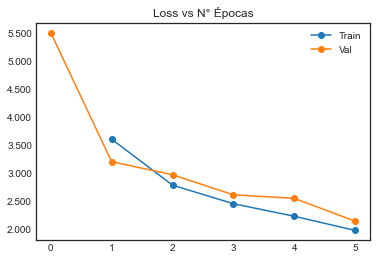

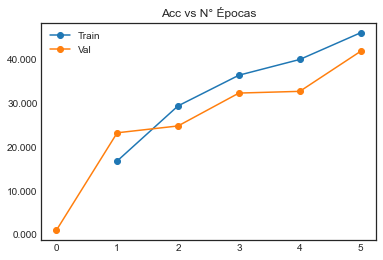

Train Loss: 1.9703 - Train Acc: 46.02%
Val Loss: 2.1352 - Val Acc: 41.80%
Test Loss: 2.1607 - Test Acc: 45.23%


In [ ]:
train_dataset.transform = transforms.Compose([
    transforms.RandomApply([HideWithBoxTransform()], p=0.5),
    transforms.Resize([224, 224]),
    to_normalized_tensor
])
val_dataset.transform = transforms.Compose([   
    transforms.Resize([224, 224]),
    to_normalized_tensor
])
test_dataset.transform = transforms.Compose([
    transforms.Resize([224, 224]),
    to_normalized_tensor
])

ex_model = get_model(n_classes=n_classes)
ex_optimizer = Adam(ex_model.parameters(), lr=learning_rate)

ex_history = run_training(ex_model, loaders, ex_optimizer, criterion, n_epochs)
ex_test_performance = run_testing(ex_model, loaders['test'], criterion, n_epochs)

print_report(ex_history, ex_test_performance)

Inspeccionemos la predicción del modelo para un ejemplo.

Ground Truth
bougainvillea

Top-5 Predictions
petunia             (p=0.0751)
lenten rose         (p=0.0693)
foxglove            (p=0.0533)
sweet pea           (p=0.0531)
siam tulip          (p=0.0473)



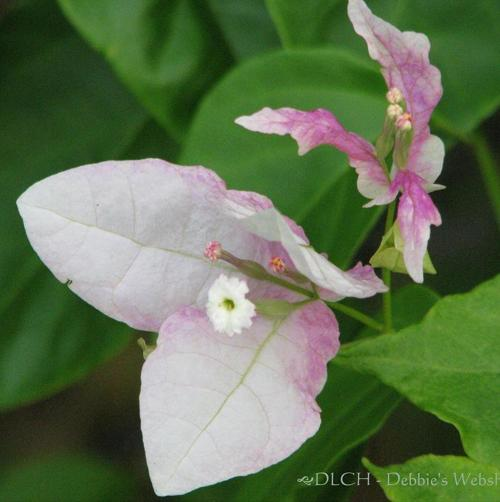

In [ ]:
show_prediction(ex_model, test_dataset, sample_idx=166) # Si omiten el sample_idx este será elegido aleatoriamente

# respuestas
1. ¿Cómo se compara el rendimiento con nuestro modelo base? ¿Y con el modelo entrenado con data augmentation que habíamos probado previamente?

|modelo       |train-acc|val-acc|test-acc|
|-------------|---------|-------|--------|
|modelo base  |   50.95%| 39.14%|  43.05%|
|augmented    |   49.55%| 40.08%|  40.62%|
|vertical flip|   44.36%| 37.50%|  41.72%|
|hidden box   |   46.44%| 40.47%|  42.89%|

2nd run
|modelo       |train-acc|val-acc|test-acc|
|-------------|---------|-------|--------|
|modelo base  |   49.86%| 39.61%|  42.11%|
|augmented    |   49.36%| 39.14%|  39.30%|
|vertical flip|   48.77%| 40.08%|  41.64%|
|hidden box   |   46.02%| 41.80%|  45.23%|

2. analice brevemente el resultado obtenido brevemente.

Me parece que las técnicas de data augmentation permiten diversificar el dataset pero con la cantidad de epocas se me hace difícil sacar conclusiones [para los resultados actuales], tengo la intuición de que con muchas mas épocas el rendimiento limite debe ser diferente (mayor para el dataset aumentado que para el base).

## Transfer Learning y Finetuning

Luego continuaremos explorando los métodos expuestos durante la clase, en esta caso aplicaremos transfer learning en la forma de finetuning.

En esta actividad aprovecharemos un modelo que previamente fue entrenado en el dataset [Imagenet](http://www.image-net.org/), el cual se ha vuelto prácticamente un standard en el área cuando se tiene en frente una tarea en imágenes. Utilizaremos el mismo modelo, ResNet18, que antes para mantener la consistencia y nuestros resultados sean comparables.

### Finetuning

Entrenemos un modelo haciendo finetuning de uno originalmente entrenado en Imagenet. Para esto es necesario conseguirnos los pesos de dicho modelo, por suerte PyTorch nos hace la vida fácil y con un simple parámetro podemos descargarlos automáticamente.

Para aprovechar los modelos de PyTorch debemos utilizar los modelos que vienen en [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html). Debemos crear un modelo llamando seteando el parámetro `pretrained=True`, esto automáticamente descargará (fijense en el *output* al momento de empezar crear el modelo) los pesos y los usará para el modelo. 

Es importante notar que la mayoría de estos modelos son preentrandos en Imagenet, pero hay algunos con otros datasets de origen, por lo que se recomienda revisar la documentación previamente a usar alguno de los modelos disponibles.

In [ ]:
ft_model = models.resnet18(pretrained=True)
ft_model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)
ft_model.to(device)
None # No queremos el output de la descripción del modelo en colab

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Arie/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.9MB/s]


### **Ejercicio II (Parte 1)**
- Explique brevemente la siguiente línea de código en el espacio que tiene a continuación.

`ft_model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)`


In [ ]:
#@title Respuesta
R = "El proposito de esta linea es cambiar la salida de las categorias, ya que nuestro nuevo dataset no tiene las mismas que imagenet" #@param {type:"string"}

Ahora hagamos el finetuning de nuestro modelo. 

Validating model before training
VAL-Batch 10/10 Loss: 4.7728 Acc: 1.02%
Epoch N°1
TRAIN-Batch 45/45 Loss: 1.7979 Acc: 62.76%
VAL-Batch 10/10 Loss: 0.7263 Acc: 83.20%
Epoch N°2
TRAIN-Batch 45/45 Loss: 0.2566 Acc: 95.12%
VAL-Batch 10/10 Loss: 0.3370 Acc: 88.44%
Epoch N°3
TRAIN-Batch 45/45 Loss: 0.0790 Acc: 97.90%
VAL-Batch 10/10 Loss: 0.2573 Acc: 90.00%
Epoch N°4
TRAIN-Batch 45/45 Loss: 0.0412 Acc: 98.28%
VAL-Batch 10/10 Loss: 0.2283 Acc: 90.78%
Epoch N°5
TRAIN-Batch 45/45 Loss: 0.0294 Acc: 98.40%
VAL-Batch 10/10 Loss: 0.2175 Acc: 90.16%
TEST-Batch 10/10 Loss: 0.2235 Acc: 94.38%

Test loss: 0.2235, Test acc.: 94.38



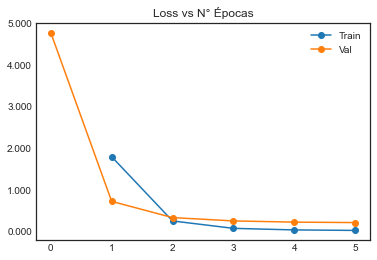

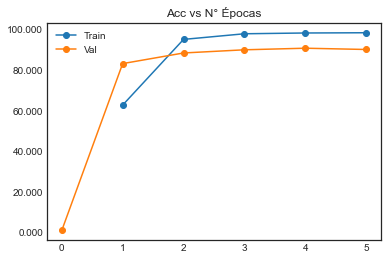

Train Loss: 0.0294 - Train Acc: 98.40%
Val Loss: 0.2175 - Val Acc: 90.16%
Test Loss: 0.2235 - Test Acc: 94.38%


In [ ]:
learning_rate = 5e-4 # podríamos usar 0.01 la learning rate 1/10 de la original (para ResNet 0.1)
ft_optimizer = Adam(ft_model.parameters(), lr=learning_rate)

ft_history = run_training(ft_model, loaders, ft_optimizer, criterion, n_epochs)
ft_test_performance = run_testing(ft_model, loaders['test'], criterion, n_epochs)

print_report(ft_history, ft_test_performance)

Inspeccionemos la predicción del modelo para un ejemplo.

Ground Truth
bougainvillea

Top-5 Predictions
bougainvillea       (p=0.9725)
mexican petunia     (p=0.0043)
canterbury bells    (p=0.0036)
mallow              (p=0.0024)
balloon flower      (p=0.0021)



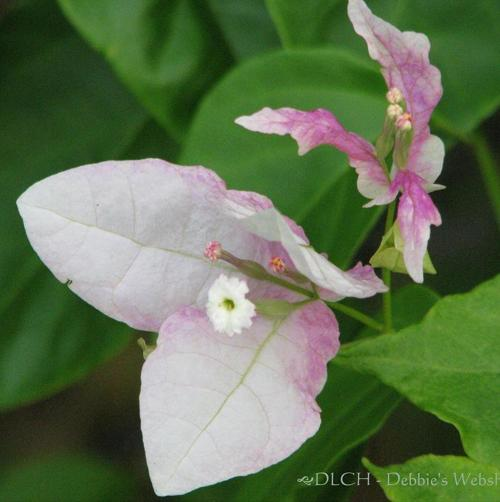

In [ ]:
show_prediction(ft_model, test_dataset, sample_idx=166) # Si omiten el sample_idx este será elegido aleatoriamente

### **Ejercicio II (Parte 2)**

- Haga una tabla resumen en donde muestre el rendimiento obtenido en los tres escenarios, base, usando data augmentation y usando finetuning, y en los 3 set de datos (train, val y test) distintos utilizados.
- Analice brevemente como se comparan los resultados. ¿Cuál escenario se llegó al mejor rendimiento? ¿Cuál es el que muestra mayor grado de sobreajuste?



# respuestas

1. tabla resumen

|modelo       |train-acc|val-acc|test-acc|
|-------------|---------|-------|--------|
|modelo base  |   49.86%| 39.61%|  42.11%|
|augmented    |   46.02%| 41.80%|  45.23%| (acá elegí las cifras de la transformacion que oculta secciones de la imagen por tener el mejor acc)
|pretrained   |   98.40%| 90.16%|  94.38%|

2. Evidentemente el modelo preentrenado tiene mejor rendimiento. Los modelos con mayor sobreajuste son los base y augmented, esto por que solo fueron entrenados en un conjunto limitado de datos. El modelo preentrenado al haber sido entrenado con muchas mas ejemplos, converge mas rapido y es mas preciso.

In [ ]:
ft_model = ft_optimizer = aug_model = aug_optimizer = model = optimizer = criterion = None
torch.cuda.empty_cache()

# Actividad II: Texto

En esta actividad aplicaremos lo que vimos en clase para un problema de clasificación de texto. En este caso veremos como usar finetuning para este dominio en particular.

**Importante.** Para facilitar su ejecución, esta sección puede ser ejecutada independientemente de la anterior.

<small>Basado en el notebook https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb

También agradecemos a Hernán Valdivieso por su script para descargar archivos desde Google Drive.</small>


## Preámbulo
Primero debemos montar nuestro drive, copiar el dataset hacia colab para luego decomprimirlo dentro del directorio data, que recién creamos. También importamos algunas de las librerías que ocuparemos durante esta actividad. 

En particular utilizaremos la libraría [*Transformers*](https://github.com/huggingface/transformers) de la empresa [HugginFace 🤗](https://huggingface.co), esta librería implementa varios de los modelos del tipo *transformer* que actualmente son de lo más utilizado para el dominio de NLP. Dentro de estos modelos destaca BERT, el cual es muy utilizado por su **buen rendimento al ser finetuneado**. 

Por el momento no entraremos en detalle de la arquitectura de *transformer*, pues lo verán en el futuro. Pero si les gana la curiosidad, les recomiendo leer el paper que los propuso, ["Attention is all you need"](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf) en NeurIPS 2017 y lo mismo con el paper de [BERT](https://arxiv.org/pdf/1810.04805.pdf) publicado en ACL 2019.

Este modelo de lenguaje será visto en otra sección del diplomado. 

In [1]:
![[ ! -f google_api.py ]] && wget -q --show-progress https://raw.githubusercontent.com/Hernan4444/MyScripts/master/google_drive/google_api.py
!mkdir -p data

google_api.py       100%[===================>]   5.55K  --.-KB/s    in 0s      


In [2]:
import os
from google_api import download_file_without_authenticate

# Descargamos nuestros datos para ser utilizados en este notebook.
if not os.path.exists('lab4.zip'):
    download_file_without_authenticate(
        '1NjcTV1SeZgYWOAZG-ig2NBpYP5EyTy8Z', 'data/jigsaw-toxic-comment-classification-challenge.zip')
    download_file_without_authenticate(
        '1ye0M-KnVtUbpIgGjogIjgWx0vReCthWA', 'data/flowers.zip')
    
!unzip -nq data/\*.zip -d data


2 archives were successfully processed.


In [3]:
# !pip install torch==1.7.0
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q transformers==3.5.1

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 24 kB/s 
     |████████████████████████████████| 12.7 MB 168 kB/s 
     |████████████████████████████████| 7.6 MB 11.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.0+cu101 which is incompatible.
     |████████████████████████████████| 1.3 MB 12.5 MB/s 
     |████████████████████████████████| 2.9 MB 49.6 MB/s 
     |███████

In [15]:
import random
import numpy as np
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# No tocar este código
random.seed(1666)
rng_state = np.random.get_state()
np.random.seed(1666)
torch.manual_seed(1666)
torch.cuda.manual_seed(1666)

In [17]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn import metrics
import transformers
from transformers import BertTokenizer, BertModel

## Primeros Pasos

### Dataset

Trabajaremos con el dataset del desafío **Jigsaw's Multilingual Toxic Comment Classification**, este dataset está basado en comentarios realizados en Wikipedia y etiquetados por anotadores humanos dependiendo de su "toxicidad". Cada comentario tiene 6 etiquetas binarias, cada una independiente de las demás. Pueden obtener el dataset original de su [página del desafío en Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).

Primero que todo, como siempre debe ser, exploraremos los datos para tener una mejor idea de con qué estamos trabajando.

Dado que los datos están de forma tabular utilizaremos [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) como herramienta para ayudarnos en esta tarea.



In [18]:
df = pd.read_csv("./data/jigsaw-toxic-comment-classification-challenge/train.csv")
task_labels = list(df.columns[2:])

In [19]:
import textwrap

def print_sample(sample):
    def yesno(bool_):
      return 'yes' if bool_ else 'no'

    print('{:<13}: {}'.format('id', sample.id), end='\n\n')

    print('{:<13}:'.format('comment_text'))
    print(textwrap.fill(sample.comment_text, 50), end='\n\n')

    print('{:<13}: {}'.format('toxic', yesno(sample.toxic)))
    print('{:<13}: {}'.format('severe_toxic', yesno(sample.severe_toxic)))
    print('{:<13}: {}'.format('obscene', yesno(sample.obscene)))
    print('{:<13}: {}'.format('threat', yesno(sample.threat)))
    print('{:<13}: {}'.format('insult', yesno(sample.insult)))
    print('{:<13}: {}'.format('identity_hate', yesno(sample.identity_hate)))


sample = df.sample().iloc[0]
print_sample(sample)

id           : 157ed05fed7f1d77

comment_text :
the Public Policy Initiative Assessment Team wants
You! Hi Morphh,   I saw some of your contributions
on an article that falls within the scope of
Wikiproject: United States Public Policy,
(Taxation in the U.S.) you seem to have a lot
edits and expertise in policy and economics, and I
was hoping you would be interested in assessing
articles with the Public Policy Initiative. There
is more info about assessment on the  9/13/2010
Signpost. If you're interested or just curious you
can sign up on the  project page or just contact
me. Thanks!

toxic        : no
severe_toxic : no
obscene      : no
threat       : no
insult       : no
identity_hate: no


In [20]:
sample = df[df[df.columns[2:]].any(axis=1)].sample().iloc[0]
print_sample(sample)

id           : 71593f2890b5b365

comment_text :
Eric W.Bragg's Surrealism: SIDEWALK STAINS  In my
lifetime, I have seen some of the most stupidest
crap that my eyes have unfortunately seen!
However, this tops them all, Eric W.Bragg
presents, SIDEWALK STAINS! (I am not making this
up):  http://www.surrealcoconut.com/surrealism_gal
lery/Found_Objects/stain.html  In the meantime,
call Sanitation Enforcement to clean these
disgusting sidewalks and then call the police to
have Bragg locked up!

toxic        : yes
severe_toxic : no
obscene      : no
threat       : no
insult       : no
identity_hate: no


Algo importante que notar es que este dataset (para cada una de las tareas) está desbalanceado, en este caso significa que la cantidad de ejemplos negativos supera en gran medida a los ejemplos negativos. Veamos el desbalance imprimiendo la proporción de ejemplos positivos por cada tarea.

In [21]:
df[df.columns[2:]].sum() / len(df)

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

Definamos algunos parámetros que serán importante para el resto de esta actividad.

In [22]:
# Defining some key variables that will be used later on in the training
subset_size = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
max_len = 200 #@param {type: "number"}
batch_size = 16 #@param {type: "number"}
n_epochs = 5  #@param {type:"slider", min:1, max:20, step:1}
learning_rate = 1e-5 #@param {type: "number"}
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [23]:
df['list'] = df[df.columns[2:]].values.tolist()
new_df = df[['comment_text', 'list']].copy()
new_df = new_df.sample(frac=subset_size, random_state=200).reset_index(drop=True)

Antes de crear cada uno de nuestros objetos `Dataset`, debemos hacer la división de los distintos sets que utilizaremos (train, val y test).

In [24]:
train_size = 0.7
train_dataset = new_df.sample(frac=train_size, random_state=200)
test_dataset = new_df.drop(train_dataset.index).reset_index(drop=True)
val_dataset = test_dataset.sample(frac=0.5, random_state=200)
test_dataset = test_dataset.drop(val_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)

In [14]:
for split, ds in [('train', train_dataset), ('val', val_dataset), ('test', test_dataset)]:
    print('{:<14s}{:>6,d}'.format(f'Dataset {split}:', len(ds)))

Dataset train: 1,117
Dataset val:     240
Dataset test:    239


Luego, debemos crear un objeto de la clase `Dataset` para utilizarlo en el entrenamiento. Para eso nos crearemos la clase `JigsawDataset` que nos ayudará con el manejo del dataset. 

In [25]:
from torch.utils.data import Dataset, DataLoader

class JigsawDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [26]:
training_set = JigsawDataset(train_dataset, tokenizer, max_len)
validating_set = JigsawDataset(val_dataset, tokenizer, max_len)
testing_set = JigsawDataset(test_dataset, tokenizer, max_len)

loaders = {
    'train': DataLoader(training_set, batch_size=batch_size, shuffle=True),
    'val': DataLoader(validating_set, batch_size=batch_size, shuffle=False),
    'test': DataLoader(testing_set, batch_size=batch_size, shuffle=False),
}

## Modelo Base

Para entrenar nuestros modelo, crearemos varias funciones para ayudarnos. Al igual que en la actividad anterior, les recomendamos que traten de entender cada una de estas funciones pues podrán solidificar conocimientos que ya han aprendido en el diplomado hasta ahora, pero para efectos de esta actividad no es necesario hacerlo.

In [6]:
def run_epoch(phase, model, loader, criterion, optimizer=None, return_predictions=False):
    n_batches = len(loader)
    if phase == 'train':
        model.train()
    elif phase == 'val' or 'test':
        model.eval()
        
    cum_loss = 0.0
    cum_acc = 0.0
    cum_preds = torch.zeros((0,6)).to(device)
    cum_targets = torch.zeros((0,6)).to(device)
    for n_batch, data in enumerate(loader, start=1):
        if phase == 'train': # Limpiamos los gradientes solo al entrenar
            optimizer.zero_grad()

        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)
        
        result = model(ids, mask, token_type_ids) # Aquí se ejecuta nuestro modelo

        loss = criterion(result, targets) # Cálculamos la pérdida
        cum_loss += loss.item()
        preds = torch.sigmoid(result) >= 0.5 # Nuestras predicciones positivas son todas las que pasan el umbral de 0.5

        cum_preds = torch.cat((cum_preds, preds))
        cum_targets = torch.cat((cum_targets, targets))

        # accuracy = calculate_metrics(targets, preds)
        cum_acc += torch.sum(preds == targets.data)
        if phase == 'train':
            loss.backward() # Hacemos backpropagation solo en train
            optimizer.step() # Actualizamos parámetros solo en train

        current_cum_loss = cum_loss / n_batch
        current_cum_acc = 100 * cum_acc / (n_batch * batch_size * 6) # son 6 tareas diferentes

        print(f'\r{phase.upper()}-Batch {n_batch}/{n_batches} '
              f'Loss: {current_cum_loss:.4f} '
              f'Acc: {current_cum_acc:.2f}% ', end='')
    
    epoch_loss = float(cum_loss / n_batch)
    epoch_acc = float(100 * cum_acc / (n_batch * batch_size * 6)) # son 6 tareas diferentes

    if return_predictions:
        return epoch_loss, epoch_acc, (cum_preds, cum_targets)

    return epoch_loss, epoch_acc

def calculate_metrics(targets, outputs):
    targets = targets.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()

    accuracy = 100 * metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    return accuracy, f1_score_micro, f1_score_macro

def run_training(model, loaders, optimizer, criterion, n_epochs):
    phases = ['train', 'val']
    history = {
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': []}
    }

    print(f"Validating model before training")
    with torch.no_grad():
        val_loss, val_acc = run_epoch('val', model, loaders['val'], criterion)
    print()

    history['val']['loss'].append(val_loss)
    history['val']['acc'].append(val_acc)
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch N°{epoch}")
        for phase in phases:
            epoch_loss, epoch_acc = run_epoch(phase, model, loaders[phase], criterion, optimizer=optimizer)
            # Registramos las pérdidas y accuracy por época, por fase
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            print("")

    return history

def run_testing(model, loader, criterion, n_epochs):
    test_loss, test_acc, (outputs, targets) = run_epoch('test', model, loader, criterion, return_predictions=True)
    accuracy, f1_score_micro, f1_score_macro = calculate_metrics(targets, outputs)
    print(f'\n\nTest loss: {test_loss:.4f}, Test acc.: {test_acc:.2f}\n')
    return {'loss': test_loss, 'acc': accuracy, 'f1_micro': f1_score_micro,
            'f1_macro': f1_score_macro, 'outputs': outputs.cpu().numpy(), 'targets': targets.cpu().numpy()}

Definamos también algunas funciones que nos ayudarán a visualizar el entrenamiento y sus resultados de mejor forma.

In [5]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn.metrics

def graph_metrics(metricas_test, metricas_train, title=''):
    fig, ax = plt.subplots()
    plt.style.use('seaborn-white')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
    plt.plot(range(1,int(len(metricas_train)+1)), metricas_train, marker='o')
    plt.plot(range(int(len(metricas_test))), metricas_test, marker='o')
    plt.legend(['Train', 'Val'])
    plt.title(title)
    plt.show()

def graph_training_metrics(history):
    for metric in ['loss', 'acc']:
        title = f'{metric.capitalize()} vs N° Épocas'
        graph_metrics(history['val'][metric], history['train'][metric], title=title)

def print_report(train_history, test_performance):
    graph_training_metrics(train_history)

    train_loss = train_history['train']['loss'][-1]
    train_acc = train_history['train']['acc'][-1]
    val_loss = train_history['val']['loss'][-1]
    val_acc = train_history['val']['acc'][-1]
    test_loss = test_performance['loss']
    test_acc = test_performance['acc']
    print(f'Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%')

def plot_cm(ax, cm, task, labels):
    cax = ax.matshow(cm, cmap='Blues')
    plt.title(f'Confusion matrix of the {task} task')
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)

    for i in range(len(cm)):
        for j in range(len(cm[0,:])):
            color = 'k' if cm[i, j] < 0.5 else 'w'
            pct = f'{cm[i, j]:.4f}'
            text = ax.text(j, i, pct, ha='center', va='center', color=color, fontsize=14)

    plt.xlabel('Predicted')
    plt.ylabel('True')

def plot_confusions(outputs, targets, labels):
    ncols, nrows = 3, 2
    fig = plt.figure(figsize=[6.4*0.75*ncols, 4.8*1*nrows])
    for task_idx, task in enumerate(labels):
        confusion_matrix = sklearn.metrics.confusion_matrix(outputs[:, task_idx], targets[:, task_idx], normalize='true')
        
        task_labels = [f'non {task}', task]
        ax = fig.add_subplot(nrows, ncols, task_idx + 1)
        plot_cm(ax, confusion_matrix, task, task_labels)

    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    plt.show()

def bold(text):
  return '\033[1m' + text + '\033[0m'

def show_prediction(model, dataset, sample_idx=None):
    if sample_idx is None:
        sample_idx = random.randrange(len(dataset))

    text = dataset.comment_text[sample_idx]
    targets = dataset.targets[sample_idx]
    sample = dataset[sample_idx]

    ids = sample['ids'].to(device, dtype=torch.long).unsqueeze(dim=0)
    mask = sample['mask'].to(device, dtype=torch.long).unsqueeze(dim=0)
    token_type_ids = sample['token_type_ids'].to(device, dtype=torch.long).unsqueeze(dim=0)
    targets = sample['targets'].to(device, dtype=torch.float).unsqueeze(dim=0)

    result = model(ids, mask, token_type_ids) # Aquí se ejecuta nuestro modelo
    results = list(torch.nn.functional.sigmoid(result).squeeze())
    targets = list(targets.squeeze())

    def yesno(bool_):
        return 'yes' if bool_ else 'no'

    tasks =  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(textwrap.fill(text, 50), end='\n\n')
    print('{:>17}  {:>14s} {:>8s}'.format('Task', 'Prediction', "Real"))
    for task, prob, gt in zip(tasks, results, targets):
        task_pred = yesno(prob > 0.5)
        gt = yesno(gt == 1)
        print('{:>17}  {:>5s} (p={:.4f}) {:>5s}'.format(task, task_pred, prob, gt))

Ocuparemos un modelo que definimos nosotros `BERTClass`, el cual toma el modelo de BERT preentrenado que nos entrega la librería `transformers` y le agregamos capas lineales para realizar la clasificación de nuestras tareas.

In [27]:
from transformers import PretrainedConfig

class BERTClass(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(BERTClass, self).__init__()
        if pretrained:
            self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        else:
            config = PretrainedConfig.from_pretrained('bert-base-uncased')
            self.l1 = transformers.BertModel(config)

        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

Entrenamos nuestro modelo base.

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Validating model before training
VAL-Batch 15/15 Loss: 0.7223 Acc: 34.58% 
Epoch N°1
TRAIN-Batch 70/70 Loss: 0.1867 Acc: 95.30% 
VAL-Batch 15/15 Loss: 0.1205 Acc: 97.36% 
Epoch N°2
TRAIN-Batch 70/70 Loss: 0.1461 Acc: 96.12% 
VAL-Batch 15/15 Loss: 0.1140 Acc: 97.36% 
Epoch N°3
TRAIN-Batch 70/70 Loss: 0.1440 Acc: 96.12% 
VAL-Batch 15/15 Loss: 0.1127 Acc: 97.36% 
Epoch N°4
TRAIN-Batch 70/70 Loss: 0.1403 Acc: 96.12% 
VAL-Batch 15/15 Loss: 0.1212 Acc: 97.36% 
Epoch N°5
TRAIN-Batch 70/70 Loss: 0.1362 Acc: 96.12% 
VAL-Batch 15/15 Loss: 0.1053 Acc: 97.57% 
TEST-Batch 15/15 Loss: 0.1270 Acc: 95.69% 

Test loss: 0.1270, Test acc.: 95.69



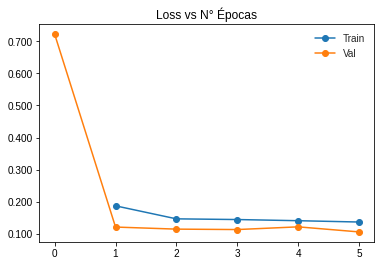

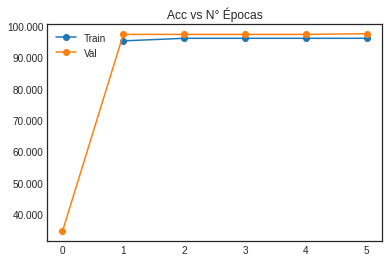

Train Loss: 0.1362 - Train Acc: 96.12%
Val Loss: 0.1053 - Val Acc: 97.57%
Test Loss: 0.1270 - Test Acc: 89.96%


In [20]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

model = BERTClass(pretrained=False)
model.to(device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

history = run_training(model, loaders, optimizer, criterion, n_epochs)
test_performance = run_testing(model, loaders['test'], criterion, n_epochs)

print_report(history, test_performance)

Y podemos evaluar nuestros resultado. Dado que nuestros datos tienen un problema de desbalance, utilizaremos la meetrica [*F-1 Score*](https://en.wikipedia.org/wiki/F1_score) en vez de la tradicional *accuracy*. También nos apoyaremos visualmente de las [matrices de confusión](https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n) que obtenemos con nuestras predicciones.

In [21]:
for metric in ['acc', 'f1_micro', 'f1_macro']:
    metric_str = str.capitalize(metric.replace('_', ' '))
    print('{:<9}: {:.4f}'.format(metric_str, test_performance[metric]))

Acc      : 89.9582
F1 micro : 0.0000
F1 macro : 0.0000


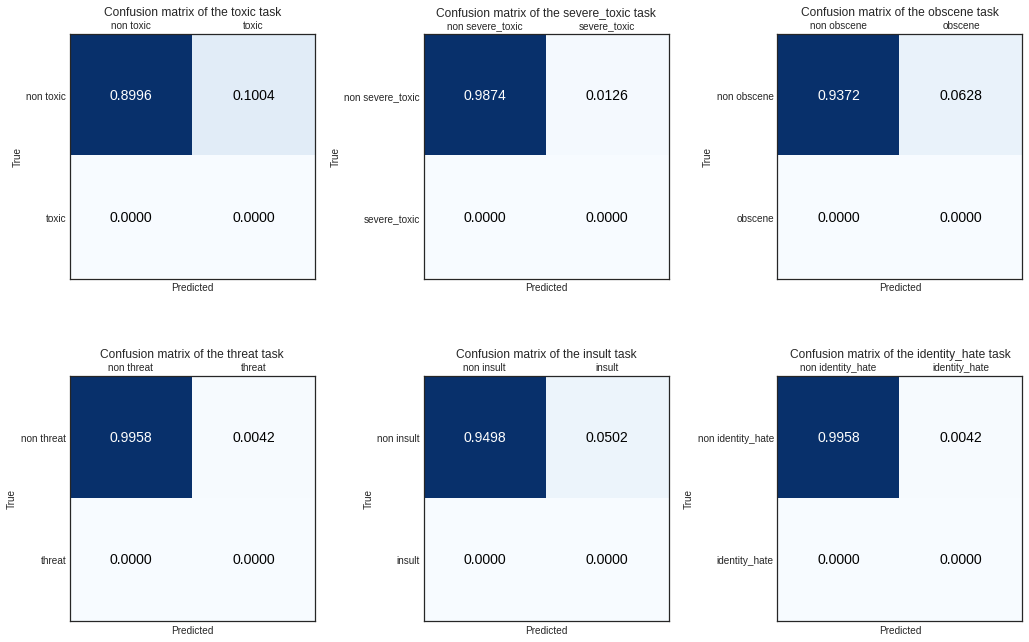

In [22]:
outputs = test_performance['outputs']
targets = test_performance['targets']
plot_confusions(outputs, targets, task_labels)

Inspeccionemos la predicción para un ejemplo.

In [23]:
show_prediction(model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

and i admit that i'm to sensitive

             Task      Prediction     Real
            toxic     no (p=0.1509)    no
     severe_toxic     no (p=0.0142)    no
          obscene     no (p=0.1066)    no
           threat     no (p=0.0084)    no
           insult     no (p=0.0947)    no
    identity_hate     no (p=0.0168)    no


El siguiente código es para liberar la memoria de la GPU, luego del entrenamineto. Así no tendremos errores por que se nos acaba la memoria.

In [24]:
model = criterion = optimizer = None

## Finetuning

Finalmente realizamos el mismo ejercicio que el anterior pero en vez de entrenar el modelo desde cero, lo entrenaremos utilizando los pesos preentrenados de BERT.

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Validating model before training
VAL-Batch 15/15 Loss: 0.6783 Acc: 50.21% 
Epoch N°1
TRAIN-Batch 70/70 Loss: 0.2872 Acc: 92.59% 
VAL-Batch 15/15 Loss: 0.1327 Acc: 97.36% 
Epoch N°2
TRAIN-Batch 70/70 Loss: 0.1207 Acc: 96.64% 
VAL-Batch 15/15 Loss: 0.0786 Acc: 98.26% 
Epoch N°3
TRAIN-Batch 70/70 Loss: 0.0679 Acc: 97.98% 
VAL-Batch 15/15 Loss: 0.0673 Acc: 97.85% 
Epoch N°4
TRAIN-Batch 70/70 Loss: 0.0509 Acc: 98.32% 
VAL-Batch 15/15 Loss: 0.0643 Acc: 97.92% 
Epoch N°5
TRAIN-Batch 70/70 Loss: 0.0400 Acc: 98.68% 
VAL-Batch 15/15 Loss: 0.0647 Acc: 97.50% 
TEST-Batch 15/15 Loss: 0.0656 Acc: 97.50% 

Test loss: 0.0656, Test acc.: 97.50



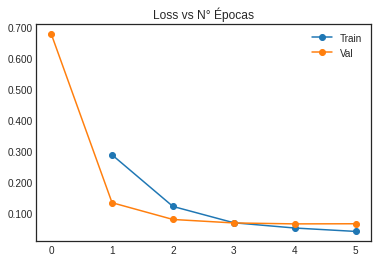

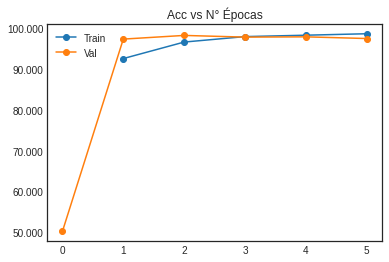

Train Loss: 0.0400 - Train Acc: 98.68%
Val Loss: 0.0647 - Val Acc: 97.50%
Test Loss: 0.0656 - Test Acc: 90.38%


In [25]:
learning_rate = 2e-5
ft_model = BERTClass(pretrained=True)
ft_model.to(device)

criterion = BCEWithLogitsLoss()
ft_optimizer = Adam(ft_model.parameters(), lr=learning_rate)

ft_history = run_training(ft_model, loaders, ft_optimizer, criterion, n_epochs)
ft_test_performance = run_testing(ft_model, loaders['test'], criterion, n_epochs)

print_report(ft_history, ft_test_performance)

In [26]:
for metric in ['acc', 'f1_micro', 'f1_macro']:
    metric_str = str.capitalize(metric.replace('_', ' '))
    print('{:<9}: {:.4f}'.format(metric_str, ft_test_performance[metric]))

Acc      : 90.3766
F1 micro : 0.7414
F1 macro : 0.3896


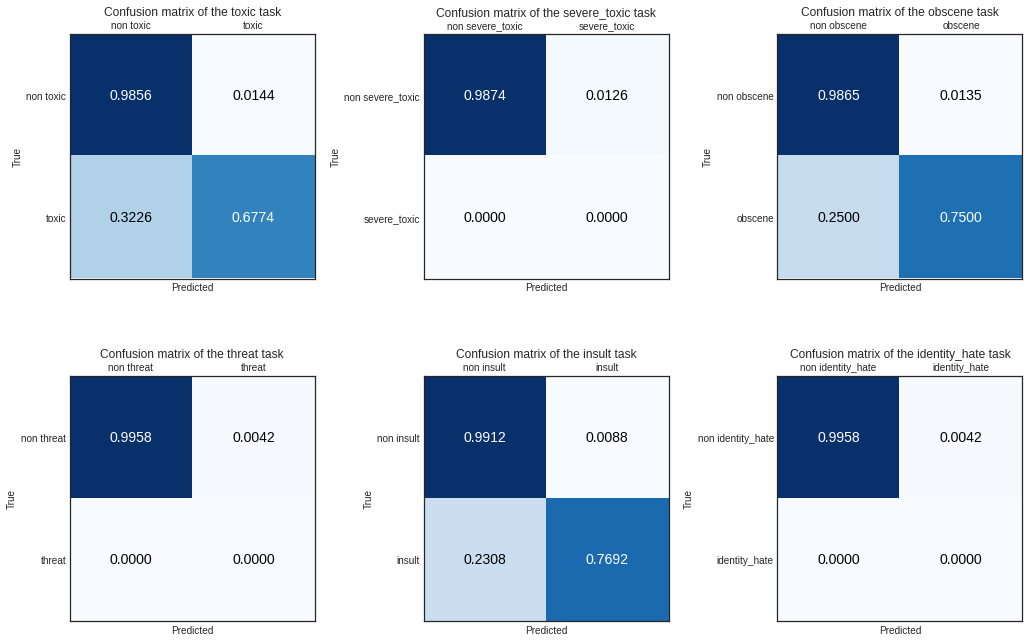

In [27]:
outputs = ft_test_performance['outputs']
targets = ft_test_performance['targets']
plot_confusions(outputs, targets, task_labels)

Inspeccionemos la predicción para un ejemplo.

In [28]:
show_prediction(ft_model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

and i admit that i'm to sensitive

             Task      Prediction     Real
            toxic     no (p=0.0080)    no
     severe_toxic     no (p=0.0086)    no
          obscene     no (p=0.0059)    no
           threat     no (p=0.0078)    no
           insult     no (p=0.0079)    no
    identity_hate     no (p=0.0071)    no


## **Ejercicio III**

Cree un modelo nuevo para realizar finetuning y pruebelo con **tres learning rates distintos** a la que utilizamos por defecto. 
- Analice brevemente el entrenamiento de los modelos (gráficos con las curvas de pérdida y *accuracy* por época), qué diferencias ve en estos.
- Analice el brevemente rendimiento en el set de test medido según la métrica *Macro F1-Score*, además tome en consideración las matrices de confusión en su análisis.

In [41]:
ft_model = criterion = ft_optimizer = None # Con esto nos evitamos problemas de memoria de la GPU
ex_model = criterion = ex_optimizer = None # Con esto nos evitamos problemas de memoria de la GPU

import gc
gc.collect()

torch.cuda.empty_cache()

Validating model before training
VAL-Batch 15/15 Loss: 0.6843 Acc: 57.57% 
Epoch N°1
TRAIN-Batch 70/70 Loss: 0.2921 Acc: 92.72% 
VAL-Batch 15/15 Loss: 0.1246 Acc: 97.36% 
Epoch N°2
TRAIN-Batch 70/70 Loss: 0.1128 Acc: 96.52% 
VAL-Batch 15/15 Loss: 0.0787 Acc: 98.19% 
Epoch N°3
TRAIN-Batch 70/70 Loss: 0.0682 Acc: 98.01% 
VAL-Batch 15/15 Loss: 0.0673 Acc: 98.19% 
Epoch N°4
TRAIN-Batch 70/70 Loss: 0.0509 Acc: 98.24% 
VAL-Batch 15/15 Loss: 0.0660 Acc: 98.12% 
Epoch N°5
TRAIN-Batch 70/70 Loss: 0.0410 Acc: 98.65% 
VAL-Batch 15/15 Loss: 0.0590 Acc: 98.19% 
TEST-Batch 15/15 Loss: 0.0533 Acc: 98.19% 

Test loss: 0.0533, Test acc.: 98.19

Validating model before training
VAL-Batch 15/15 Loss: 0.8344 Acc: 15.21% 
Epoch N°1
TRAIN-Batch 70/70 Loss: 0.1836 Acc: 94.48% 
VAL-Batch 15/15 Loss: 0.0832 Acc: 97.85% 
Epoch N°2
TRAIN-Batch 70/70 Loss: 0.0755 Acc: 97.41% 
VAL-Batch 15/15 Loss: 0.0811 Acc: 97.92% 
Epoch N°3
TRAIN-Batch 70/70 Loss: 0.0540 Acc: 98.05% 
VAL-Batch 15/15 Loss: 0.0662 Acc: 98.12% 
E

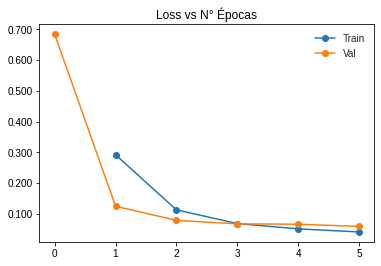

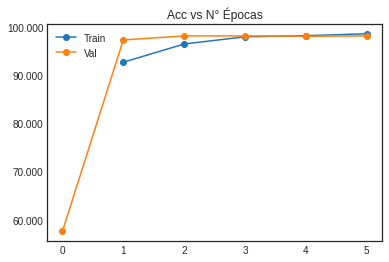

Train Loss: 0.0410 - Train Acc: 98.65%
Val Loss: 0.0590 - Val Acc: 98.19%
Test Loss: 0.0533 - Test Acc: 93.31%


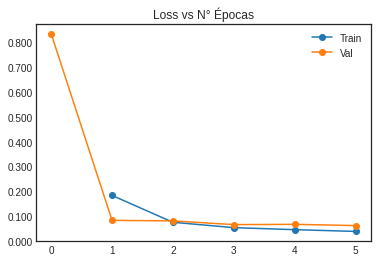

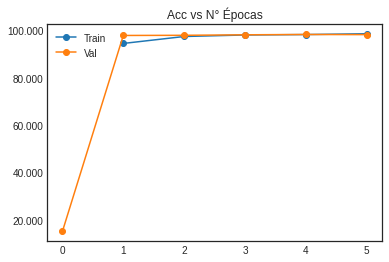

Train Loss: 0.0387 - Train Acc: 98.57%
Val Loss: 0.0623 - Val Acc: 98.19%
Test Loss: 0.0555 - Test Acc: 90.79%


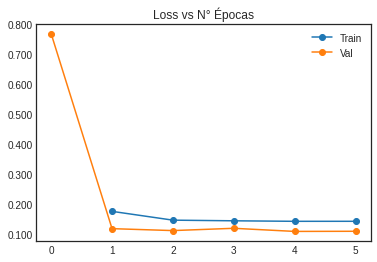

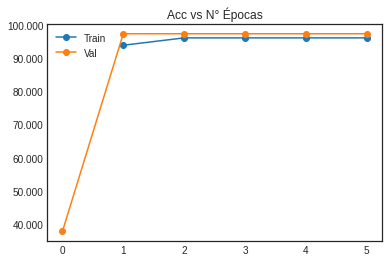

Train Loss: 0.1440 - Train Acc: 96.12%
Val Loss: 0.1108 - Val Acc: 97.36%
Test Loss: 0.1495 - Test Acc: 89.96%


In [30]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

ex_history = []
ex_test_performance = []

for learning_rate in [2e-5, 1e-4, 1e-3]:
    ex_model = BERTClass(pretrained=True)
    ex_model.to(device)

    criterion = BCEWithLogitsLoss()
    ex_optimizer = Adam(ex_model.parameters(), lr=learning_rate)

    ex_history.append(run_training(ex_model, loaders, ex_optimizer, criterion, n_epochs))
    ex_test_performance.append(run_testing(ex_model, loaders['test'], criterion, n_epochs))

    ft_model = criterion = ft_optimizer = None # Con esto nos evitamos problemas de memoria de la GPU
    ex_model = criterion = ex_optimizer = None # Con esto nos evitamos problemas de memoria de la GPU

for h, t in zip(ex_history, ex_test_performance):
    print_report(h, t)

In [31]:
for perf in ex_test_performance:
  for metric in ['acc', 'f1_micro', 'f1_macro']:
      metric_str = str.capitalize(metric.replace('_', ' '))
      print('{:<9}: {:.4f}'.format(metric_str, perf[metric]))

Acc      : 93.3054
F1 micro : 0.8039
F1 macro : 0.4302
Acc      : 90.7950
F1 micro : 0.7200
F1 macro : 0.3826
Acc      : 89.9582
F1 micro : 0.0000
F1 macro : 0.0000


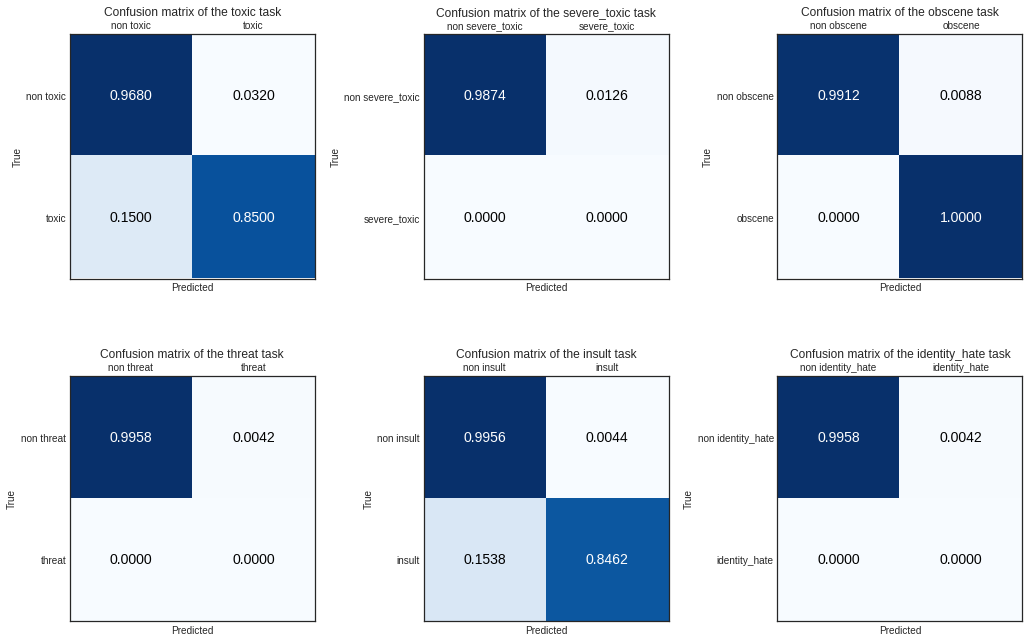

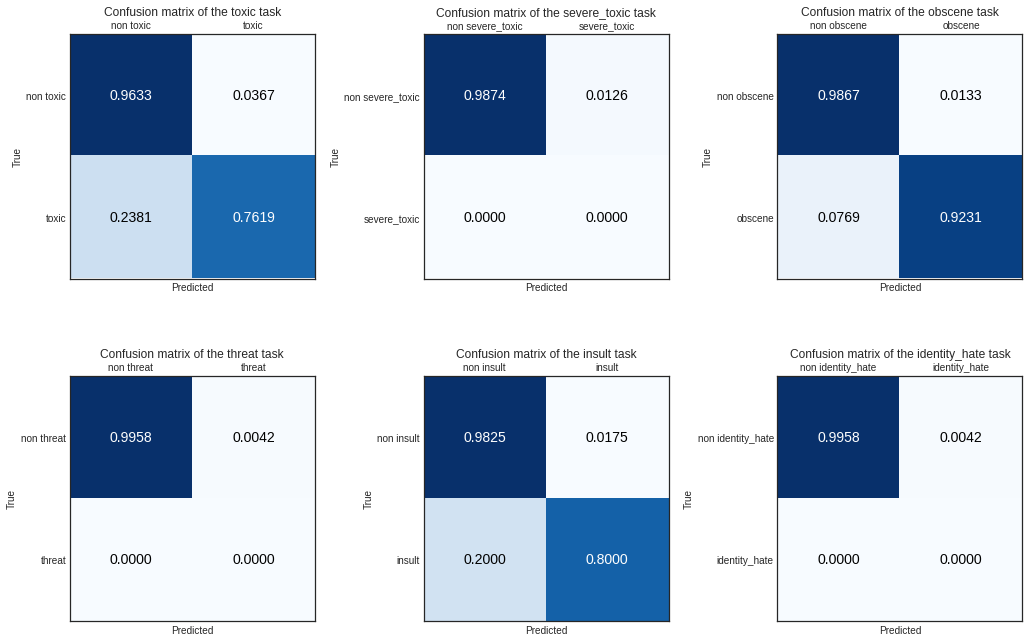

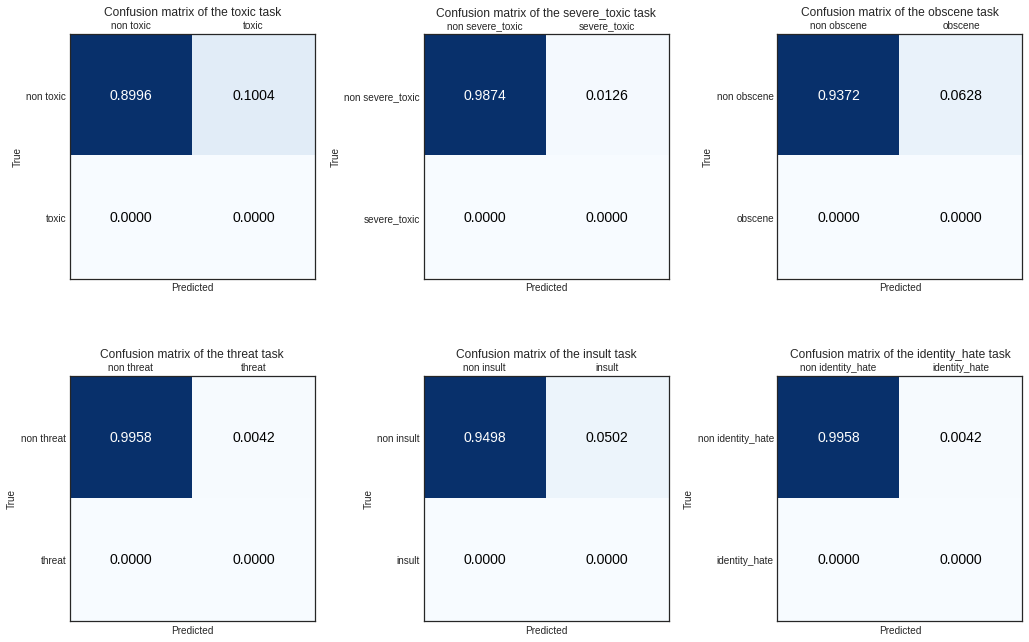

In [32]:
for perf in ex_test_performance:
  plot_confusions(perf['outputs'], perf['targets'], task_labels)

In [ ]:
show_prediction(ex_model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

# Respuesta

|learning rate|acc    |f1 micro|f1 macro|
|-------------|-------|--------|--------|
|2e-5         |93.3054|0.8039  |0.4302  |
|1e-4         |90.7950|0.7200  |0.3826  |
|1e-3         |89.9582|0.0000  |0.0000  |


**Responda las siguientes preguntas:**

En base a los modelos entrenados, ¿con qué *learning rate* utilizaría para entrenar un modelo? Justifique muy brevemente.



In [35]:
R = "Seg\xFAn los resultados de la tabla, 2e-5 es una buena opci\xF3n, el accuracy y el f1 es m\xE1s alto que para los dem\xE1s LR" #@param {type:"string"}

Proponga una forma de data augmentation que cree que ayudaría para este problema. 

In [34]:
R = "Creo que usar sinonimos podr\xEDa servir bastante, tambien eliminar ciertas palabras de las oraciones. Usualmente un humano podr\xEDa entender las oraciones usando estas t\xE9cnicas" #@param {type:"string"}

# Anexo


## ¿Cómo entrenar algunas capas del modelo?

Para poder congelar capas en una red para que no sean entrenadas solo debemos setear como false el atributo de dichos parámetros, como se muestra a continuación. deben copiar y adaptar este snippet de código para el caso que les interese.

En particular deben setear como `False` el campo `requires_grad` de los parámetros que quieren congelar.

In [ ]:
# # Con esto congelamos todas las capas
# for param in model.parameters():
#     param.requires_grad = False

# model.fc.requires_grad = True # Descongelamos las capas que queremos entrenar